In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import mutual_info_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_data(n=2000, dim=10, noise=0.5):
    H = np.random.randint(0, 2, size=(n, 1))
    W = np.random.randn(dim, 1) * 0.5
    X = H @ W.T + np.random.randn(n, dim) * noise

    X, H = shuffle(X, H)
    return torch.tensor(X).float(), torch.tensor(H).float(), torch.tensor(W).float()

def calc_mi(z, h, bins=20):
    z_np = z.detach().cpu().numpy()
    h_np = h.cpu().numpy().flatten()
    z_disc = np.digitize(z_np, bins=np.histogram_bin_edges(z_np, bins))

    scores = [mutual_info_score(z_disc[:, i], h_np) for i in range(z_disc.shape[1])]
    return np.mean(scores)

class Net(nn.Module):
    def __init__(self, dim, hidden=32, latent=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, latent)
        )

    def forward(self, x):
        return self.net(x)



In [7]:
# exp

def run_loop(X, H, W, steps=15, alpha=0.1, lr=0.01):
    model = Net(X.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    X_curr = X.clone().to(device) # dynamic world
    H = H.to(device)
    W = W.to(device)

    mi_log = []

    print(f"Running simulation on {device}...")

    for i in range(steps):
        ds = TensorDataset(X_curr, H)
        dl = DataLoader(ds, batch_size=64, shuffle=True)

    # train
        model.train()
        for _ in range(5):
            for x_b, h_b in dl:
                optimizer.zero_grad()
                z = model(x_b)
                # simple proxy task: predict H from latent mean
                pred = z.mean(dim=1, keepdim=True)
                loss = F.mse_loss(pred, h_b)
                loss.backward()
                optimizer.step()
        #feedb
        model.eval()
        with torch.no_grad():
            z_all = model(X_curr)
            mi = calc_mi(z_all, H)
            mi_log.append(mi)

            preds = z_all.mean(dim=1, keepdim=True)
            feedback = preds @ W.T

            # update cure=rent
            X_curr += alpha * (feedback * 0.1)

        print(f"Step {i+1}: MI = {mi:.4f}")

    return mi_log, X_curr.cpu()


Running simulation on cuda...
Step 1: MI = 0.5007
Step 2: MI = 0.4965
Step 3: MI = 0.4988
Step 4: MI = 0.5037
Step 5: MI = 0.5015
Step 6: MI = 0.5092
Step 7: MI = 0.5061
Step 8: MI = 0.5145
Step 9: MI = 0.5046
Step 10: MI = 0.5143
Step 11: MI = 0.5056
Step 12: MI = 0.5082
Step 13: MI = 0.5060
Step 14: MI = 0.4984
Step 15: MI = 0.5073


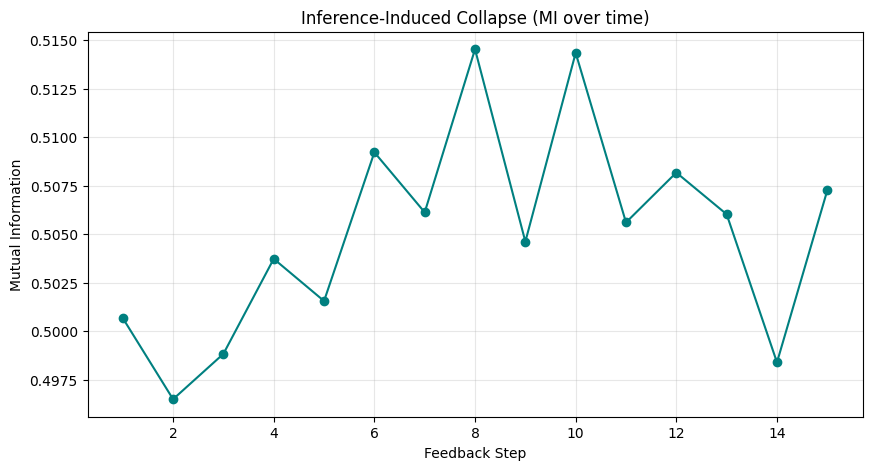

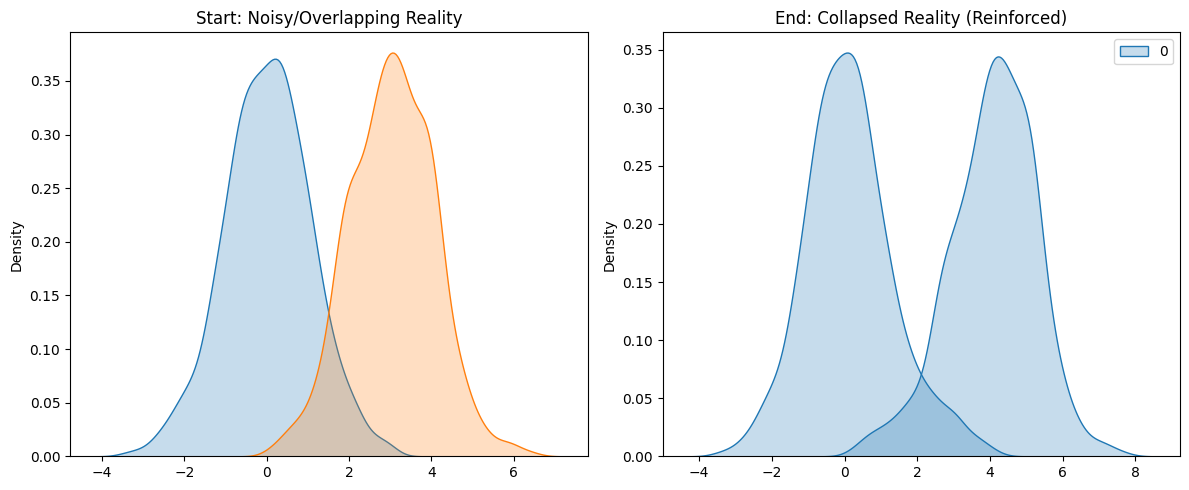

In [8]:


#main

dim = 10
X, H, W = get_data(n=2000, dim=dim, noise=0.6) # high noise initially

mi_history, X_final = run_loop(X, H, W, steps=15, alpha=0.25)

#results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(mi_history)+1), mi_history, 'o-', color='teal')
plt.title("Inference-Induced Collapse (MI over time)")
plt.xlabel("Feedback Step")
plt.ylabel("Mutual Information")
plt.grid(True, alpha=0.3)
plt.show()
#data collapse
W_np = W.numpy()
proj_start = X.numpy() @ W_np
proj_end = X_final.numpy() @ W_np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(proj_start[H.numpy()==0], fill=True, ax=axes[0], label='H=0')
sns.kdeplot(proj_start[H.numpy()==1], fill=True, ax=axes[0], label='H=1')
axes[0].set_title("Start: Noisy/Overlapping Reality")

sns.kdeplot(proj_end[H.numpy().flatten()==0], fill=True, ax=axes[1], label='H=0')
sns.kdeplot(proj_end[H.numpy().flatten()==1], fill=True, ax=axes[1], label='H=1')
axes[1].set_title("End: Collapsed Reality (Reinforced)")

plt.tight_layout()
plt.show()